## - Libraries and tensorflow model

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import re
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report
from scipy.stats import hmean
from scipy.stats.mstats import gmean
import xgboost as xgb
from xgboost import XGBClassifier

nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siddharth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Siddharth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Siddharth\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data

In [2]:
train_path = "disaster_response_messages_training.csv"
test_path = "disaster_response_messages_test.csv"
val_path = "disaster_response_messages_validation.csv"

In [3]:
d_train = pd.read_csv(train_path)
d_test = pd.read_csv(test_path)
d_val = pd.read_csv(val_path)

C:\Users\Siddharth\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
target_cols = d_train.columns[5:]

In [5]:
for i in target_cols:
    print(i)
    print(d_train[i].value_counts())

related
1    15795
0     5083
2      168
Name: related, dtype: int64
PII
0    21046
Name: PII, dtype: int64
request
0    17486
1     3560
Name: request, dtype: int64
offer
0    21046
Name: offer, dtype: int64
aid_related
0    12361
1     8685
Name: aid_related, dtype: int64
medical_help
0    19392
1     1654
Name: medical_help, dtype: int64
medical_products
0    19975
1     1071
Name: medical_products, dtype: int64
search_and_rescue
0    20426
1      620
Name: search_and_rescue, dtype: int64
security
0    20644
1      402
Name: security, dtype: int64
military
0    20382
1      664
Name: military, dtype: int64
child_alone
0    21046
Name: child_alone, dtype: int64
water
0    19725
1     1321
Name: water, dtype: int64
food
0    18717
1     2329
Name: food, dtype: int64
shelter
0    19168
1     1878
Name: shelter, dtype: int64
clothing
0    20723
1      323
Name: clothing, dtype: int64
money
0    20559
1      487
Name: money, dtype: int64
missing_people
0    20794
1      252
Name: missing

In [6]:
def get_results(y_test, y_pred):
    results = pd.DataFrame(columns=['Category', 'f_score', 'precision', 'recall'])
    num = 0
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        results.set_value(num+1, 'Category', cat)
        results.set_value(num+1, 'f_score', f_score)
        results.set_value(num+1, 'precision', precision)
        results.set_value(num+1, 'recall', recall)
        num += 1
    print('Aggregated f_score:', results['f_score'].mean())
    print('Aggregated precision:', results['precision'].mean())
    print('Aggregated recall:', results['recall'].mean())
    return results

In [7]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)
def multioutput_fscore(y_true,y_pred,beta=1):
    score_list = []
    if isinstance(y_pred, pd.DataFrame) == True:
        y_pred = y_pred.values
    if isinstance(y_true, pd.DataFrame) == True:
        y_true = y_true.values
    for column in range(0,y_true.shape[1]):
        score = fbeta_score(y_true[:,column],y_pred[:,column],beta,average='weighted')
        score_list.append(score)
    f1score_numpy = np.asarray(score_list)
    f1score_numpy = f1score_numpy[f1score_numpy<1]
    f1score = gmean(f1score_numpy)
    return  f1score

In [8]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [9]:
def model_pipeline():
    pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist',predictor='gpu_predictor',n_estimators=100, max_depth=5,
                                                    objective='multi:softmax',num_class=37,verbose=True)))
    ])

    return pipeline

In [10]:
X_train = d_train['message']
Y_train = d_train.iloc[:,5:]
X_test = d_test['message']
Y_test = d_test.iloc[:,5:]

In [11]:
model = []
model = model_pipeline()
model.fit(X_train, Y_train)

[13:05:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:15:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

[15:42:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:50:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:57:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x0000024AA7106790>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('starting_verb',
                                                 StartingVerbExtractor())])),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               c...
                                                 

In [13]:
pickle.dump(model, open("classifier_new.pkl", 'wb'))

In [14]:
y_pred = model.predict(X_test)

In [15]:
msg = ['Hello I see fire in the street and many houses are destroyed, homeless people everywhere']
test_output = model.predict(msg)
print(Y_train.columns.values[(test_output.flatten()==1)])

['related' 'aid_related' 'shelter' 'buildings' 'fire' 'direct_report']


In [16]:

multi_f1 = multioutput_fscore(Y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == Y_test).mean().mean()

print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))

Average overall accuracy 95.96% 

F1 score (custom definition) 95.21%



C:\Users\Siddharth\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [17]:
from sklearn.metrics import precision_recall_fscore_support
def get_results(y_test, y_pred):
    results = pd.DataFrame(columns=['Category', 'f_score', 'precision', 'recall'])
    num = 0
    for cat in y_test.columns:
        precision, recall, f_score, support = precision_recall_fscore_support(y_test[cat], y_pred[:,num], average='weighted')
        results.at[num+1, 'Category']= cat
        results.at[num+1, 'f_score']= f_score
        results.at[num+1, 'precision']= precision
        results.at[num+1, 'recall']= recall
        num += 1
    print('Aggregated f_score:', results['f_score'].mean())
    print('Aggregated precision:', results['precision'].mean())
    print('Aggregated recall:', results['recall'].mean())
    return results

In [18]:
get_results(Y_test, y_pred)

Aggregated f_score: 0.955974117207093
Aggregated precision: 0.9554633911004455
Aggregated recall: 0.9595982441170726


C:\Users\Siddharth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Category,f_score,precision,recall
1,related,0.849293,0.847047,0.852035
2,PII,1,1,1
3,request,0.892269,0.897126,0.900342
4,offer,0.932628,0.91152,0.954736
5,aid_related,0.784259,0.793116,0.788513
6,medical_help,0.913511,0.910351,0.923925
7,medical_products,0.968458,0.96765,0.971092
8,search_and_rescue,0.990606,0.990202,0.991251
9,security,0.991448,0.990131,0.993153
10,military,0.963414,0.96301,0.968809


In [30]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      21046 non-null  int64 
 1   split                   21046 non-null  object
 2   message                 21046 non-null  object
 3   original                8191 non-null   object
 4   genre                   21046 non-null  object
 5   related                 21046 non-null  int64 
 6   PII                     21046 non-null  int64 
 7   request                 21046 non-null  int64 
 8   offer                   21046 non-null  int64 
 9   aid_related             21046 non-null  int64 
 10  medical_help            21046 non-null  int64 
 11  medical_products        21046 non-null  int64 
 12  search_and_rescue       21046 non-null  int64 
 13  security                21046 non-null  int64 
 14  military                21046 non-null  int64 
 15  ch

In [33]:
d_train.describe()

,id,related,PII,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,21046.000000,21046.000000,21046.0,21046.000000,21046.0,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,...,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000
mean,15207.883873,0.766464,0.0,0.169153,0.0,0.412667,0.078590,0.050889,0.029459,0.019101,...,0.012259,0.046945,0.278675,0.080633,0.093747,0.011356,0.094032,0.020194,0.054072,0.190488
std,8828.189299,0.441556,0.0,0.374896,0.0,0.492326,0.269104,0.219775,0.169094,0.136883,...,0.110042,0.211526,0.448358,0.272277,0.291483,0.105961,0.291880,0.140666,0.226165,0.392695
min,2.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7430.250000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15618.500000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22910.750000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.000000,2.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
d_train.describe(include=np.object)

,split,message,original,genre
count,21046,21046,8191,21046
unique,1,20992,7807,3
top,train,"As the harsh winter sets in, more people are i...",Un front froid se retrouve sur Cuba ce matin. ...,news
freq,21046,2,17,10450


In [35]:
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

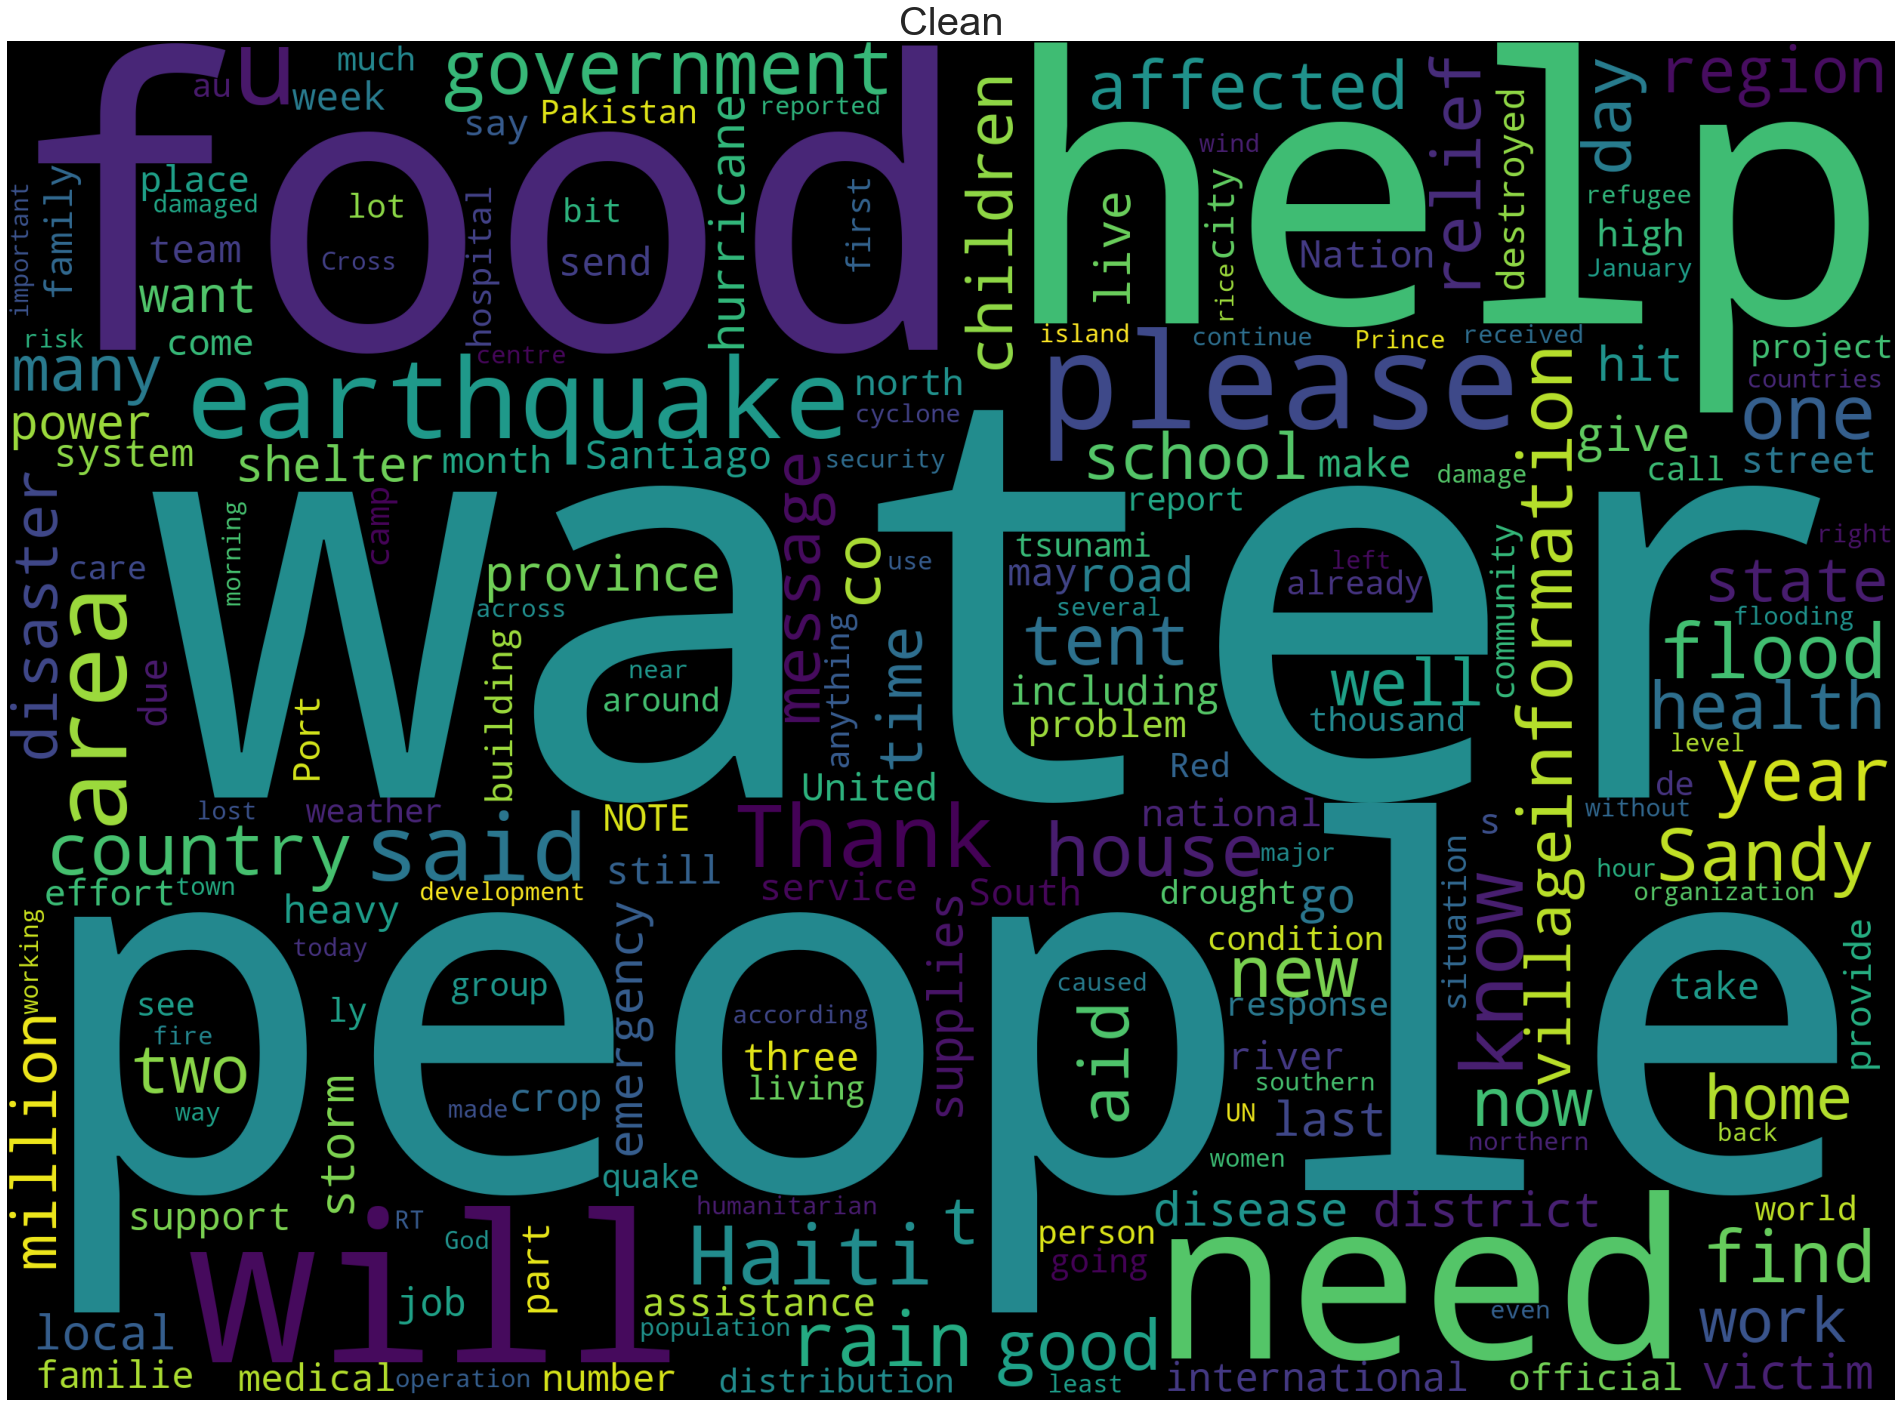

In [60]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# clean
subset = d_train
text = subset.message.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_toxic)

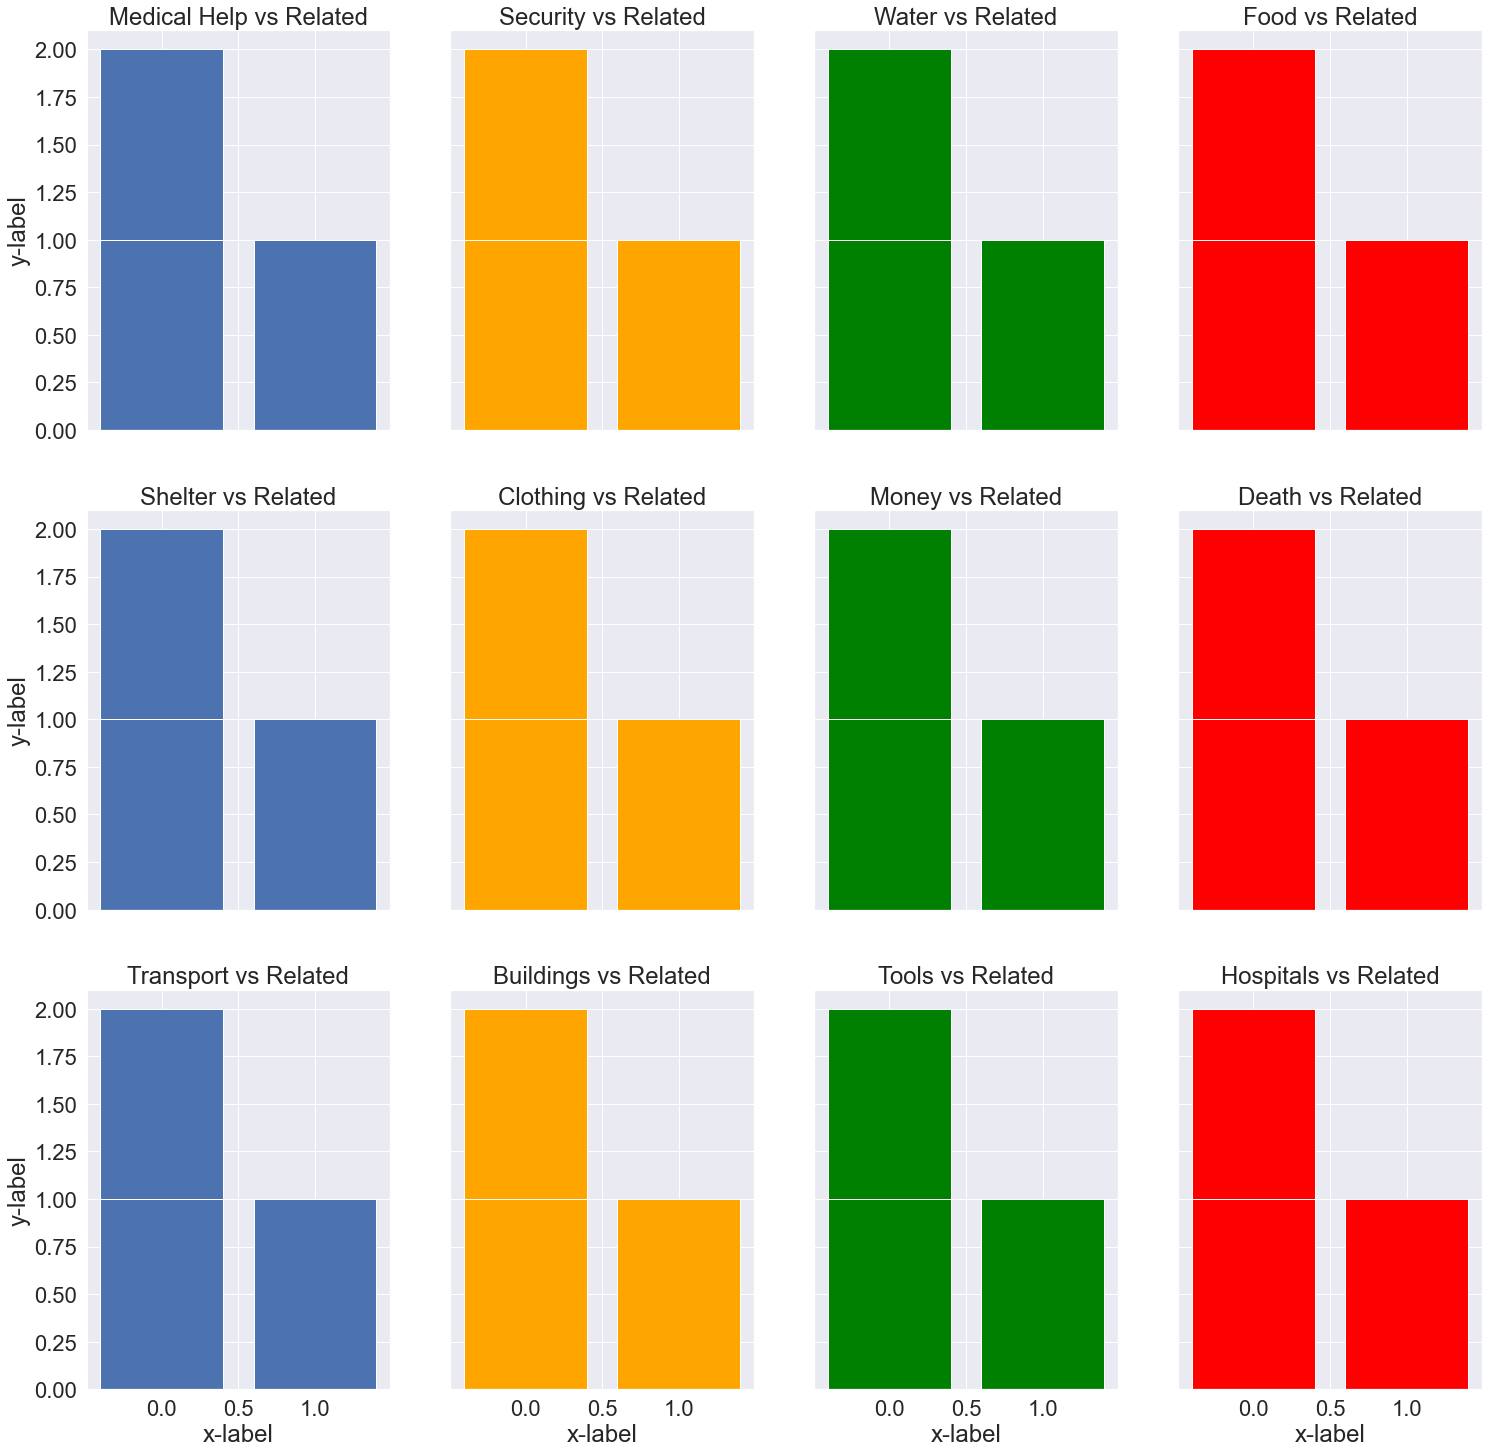

In [85]:
fig, axs = plt.subplots(3, 4,figsize=(25,25))
axs[0, 0].bar(d_train['medical_help'], d_train['related'])
axs[0, 0].set_title('Medical Help vs Related')
axs[0, 1].bar(d_train['security'], d_train['related'], color = 'orange')
axs[0, 1].set_title('Security vs Related')
axs[0, 2].bar(d_train['water'], d_train['related'], color = 'green')
axs[0, 2].set_title('Water vs Related')
axs[0, 3].bar(d_train['food'], d_train['related'], color = 'red')
axs[0, 3].set_title('Food vs Related')
axs[1, 0].bar(d_train['shelter'], d_train['related'])
axs[1, 0].set_title('Shelter vs Related')
axs[1, 1].bar(d_train['clothing'], d_train['related'], color = 'orange')
axs[1, 1].set_title('Clothing vs Related')
axs[1, 2].bar(d_train['money'], d_train['related'], color = 'green')
axs[1, 2].set_title('Money vs Related')
axs[1, 3].bar(d_train['death'], d_train['related'], color = 'red')
axs[1, 3].set_title('Death vs Related')
axs[2, 0].bar(d_train['transport'], d_train['related'])
axs[2, 0].set_title('Transport vs Related')
axs[2, 1].bar(d_train['buildings'], d_train['related'], color = 'orange')
axs[2, 1].set_title('Buildings vs Related')
axs[2, 2].bar(d_train['tools'], d_train['related'], color = 'green')
axs[2, 2].set_title('Tools vs Related')
axs[2, 3].bar(d_train['hospitals'], d_train['related'], color = 'red')
axs[2, 3].set_title('Hospitals vs Related')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()